In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px
import cv2

In [2]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class CnnVariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=784):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        x = F.relu(self.decoder_layer_1(z))
        reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        
        return reconstruction, mu, log_var
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [3]:
class AutoencoderDataset(Dataset):         
    def __init__(self, x):    
        self.x = x

        self.n_samples = len(x)
                                                                  
    def __getitem__(self, index):                   
        return self.x[index], self.x[index]                
                                                     
    def __len__(self):                                                                                   
        return self.n_samples

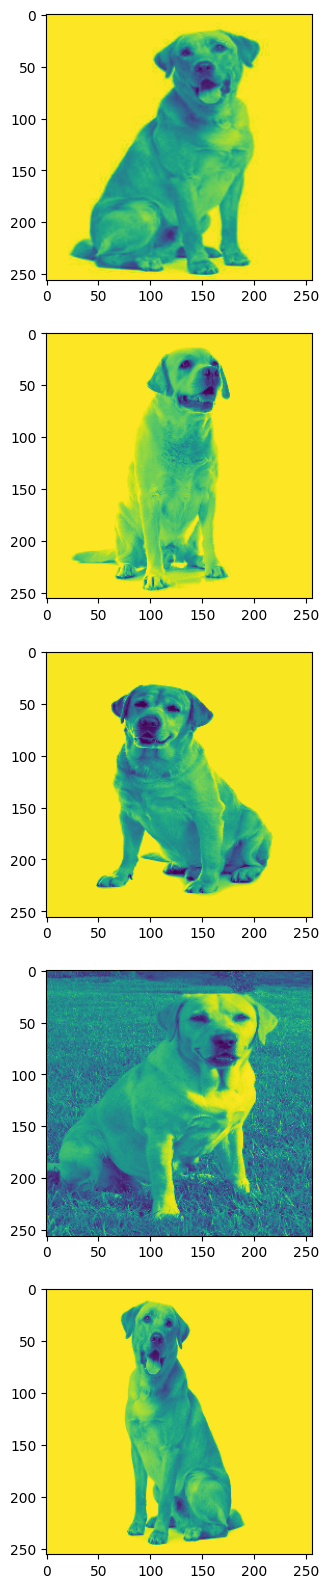

In [4]:
img_width = 256
img_height = 256

dim = (img_width, img_height)

doggos = [
    "./images/labrador1.jpg",
    "./images/labrador2.jpg",
    "./images/labrador3.jpg",
    "./images/labrador4.jpg",
    "./images/labrador5.jpg"
]

images = []

for doggo in doggos:
    img = cv2.imread(doggo, 0) / 255 # read as grayscale 1 channel images and normalize
    
    img = cv2.resize(img, dim)
    
    images.append(img)

num_images = len(images)
num_cols   = 1

col_names = [
    "Original"
]

fig, axes = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(num_cols*4, num_images*4))
counter = 0

for img in images:
    counter += 1
    
    plt.subplot(len(images), num_cols, counter)
    plt.imshow(img)

In [5]:
data = []

for img in images:
    data.append(img.ravel())
    
data

[array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0.99215686, 0.99215686, 0.99215686, ..., 0.99215686, 0.99215686,
        0.99215686]),
 array([0.22478554, 0.33698683, 0.33452819, ..., 0.28356311, 0.28727022,
        0.3173943 ]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [6]:
x = torch.Tensor(np.array(data))

x

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
        [0.2248, 0.3370, 0.3345,  ..., 0.2836, 0.2873, 0.3174],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [7]:
device = 'cpu'
learning_rate = 0.001
epochs = 100
batch_size = 1
num_features=8
num_dim=65536

model = VariationalAutoencoder(num_features=num_features, num_dim=num_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

In [8]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
train_ds = AutoencoderDataset(
    x=x
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [10]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    ave_loss = 0.0
    count = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data    = data.to(device=device)
        targets = targets.to(device=device)

        # Backward
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model.forward(data)
        
        bce_loss = criterion(reconstruction, data)
        
        loss = final_loss(bce_loss, mu, logvar)

        loss.backward()

        optimizer.step()

        # update tqdm
        loop.set_postfix(loss=loss.item())

        ave_loss += loss.item()
        count += 1

    ave_loss = ave_loss / count

    return ave_loss

In [11]:
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    ave_loss = train_fn(train_loader, model, optimizer, final_loss)
    print("Ave Loss: {}".format(ave_loss))

    state = {
        'state_dict':       model.state_dict(),
        'optimizer':        optimizer.state_dict()
    }
    
    torch.save(state, "autoencoder.pth")
    
    losses.append(ave_loss)

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s, loss=7.14e+4]


Ave Loss: 80468332.4796875
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s, loss=3.36e+4]


Ave Loss: 126472.834375
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s, loss=2.6e+4]


Ave Loss: 34178.6203125
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s, loss=2.25e+4]


Ave Loss: 84560.279296875
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s, loss=2.5e+4]


Ave Loss: 33919.5484375
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s, loss=2.18e+4]


Ave Loss: 36168.9765625
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s, loss=2.03e+4]


Ave Loss: 36498.78515625
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s, loss=1.94e+4]


Ave Loss: 31019.843359375
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s, loss=1.85e+4]


Ave Loss: 30258.499609375
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.76e+4]


Ave Loss: 30458.975390625
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s, loss=1.78e+4]


Ave Loss: 28959.935546875
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s, loss=1.66e+4]


Ave Loss: 28936.2609375
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.76e+4]


Ave Loss: 28182.026171875
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.66e+4]


Ave Loss: 28459.233984375
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s, loss=1.72e+4]


Ave Loss: 27990.819140625
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s, loss=1.9e+4]


Ave Loss: 28540.044140625
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s, loss=1.79e+4]


Ave Loss: 28459.86171875
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s, loss=1.66e+4]


Ave Loss: 28747.83828125
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s, loss=1.78e+4]


Ave Loss: 28559.63359375
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s, loss=1.71e+4]


Ave Loss: 28045.263671875
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s, loss=1.68e+4]


Ave Loss: 28117.123828125
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s, loss=1.75e+4]


Ave Loss: 27794.6458984375
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s, loss=1.71e+4]


Ave Loss: 27786.63359375
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s, loss=1.69e+4]


Ave Loss: 27800.051953125
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s, loss=1.71e+4]


Ave Loss: 27732.924609375
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.62it/s, loss=1.72e+4]


Ave Loss: 27577.214453125
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s, loss=1.68e+4]


Ave Loss: 27550.78828125
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s, loss=1.7e+4]


Ave Loss: 27488.7587890625
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.7e+4]


Ave Loss: 27428.5515625
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s, loss=1.68e+4]


Ave Loss: 27457.248046875
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s, loss=1.7e+4]


Ave Loss: 27409.4755859375
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s, loss=1.7e+4]


Ave Loss: 27370.237890625
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s, loss=1.69e+4]


Ave Loss: 27389.269140625
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s, loss=1.69e+4]


Ave Loss: 27348.31328125
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s, loss=1.7e+4]


Ave Loss: 27364.808203125
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s, loss=1.69e+4]


Ave Loss: 27372.856640625
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s, loss=1.69e+4]


Ave Loss: 27313.50234375
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.62it/s, loss=1.69e+4]


Ave Loss: 27359.700390625
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s, loss=1.7e+4]


Ave Loss: 27285.35546875
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.61it/s, loss=1.68e+4]


Ave Loss: 27329.319140625
Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.69e+4]


Ave Loss: 27271.9275390625
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s, loss=1.69e+4]


Ave Loss: 27304.2734375
Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s, loss=1.69e+4]


Ave Loss: 27259.2439453125
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s, loss=1.68e+4]


Ave Loss: 27281.1384765625
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s, loss=1.69e+4]


Ave Loss: 27225.4197265625
Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.68e+4]


Ave Loss: 27249.446875
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.69e+4]


Ave Loss: 27199.91328125
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s, loss=1.69e+4]


Ave Loss: 27179.937109375
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s, loss=1.68e+4]


Ave Loss: 27203.7744140625
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s, loss=1.69e+4]


Ave Loss: 27069.8724609375
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s, loss=1.69e+4]


Ave Loss: 27234.615234375
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s, loss=1.69e+4]


Ave Loss: 27213.1685546875
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s, loss=1.67e+4]


Ave Loss: 27215.4392578125
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s, loss=1.69e+4]


Ave Loss: 27098.58671875
Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s, loss=1.67e+4]


Ave Loss: 27158.1369140625
Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s, loss=1.67e+4]


Ave Loss: 27080.0900390625
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s, loss=1.7e+4]


Ave Loss: 27061.483984375
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s, loss=1.66e+4]


Ave Loss: 27199.787890625
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s, loss=1.68e+4]


Ave Loss: 27013.868359375
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.68e+4]


Ave Loss: 27050.3412109375
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.69e+4]


Ave Loss: 27065.2611328125
Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s, loss=1.67e+4]


Ave Loss: 27065.1470703125
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s, loss=1.69e+4]


Ave Loss: 27020.09609375
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s, loss=1.67e+4]


Ave Loss: 27097.0234375
Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s, loss=1.68e+4]


Ave Loss: 27021.8640625
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s, loss=1.69e+4]


Ave Loss: 27077.714453125
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.67e+4]


Ave Loss: 27132.4119140625
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s, loss=1.7e+4]


Ave Loss: 27061.14140625
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.66e+4]


Ave Loss: 27096.753515625
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s, loss=1.7e+4]


Ave Loss: 26910.68515625
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s, loss=1.65e+4]


Ave Loss: 27035.253515625
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s, loss=1.7e+4]


Ave Loss: 26929.1970703125
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s, loss=1.66e+4]


Ave Loss: 27134.094921875
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s, loss=1.7e+4]


Ave Loss: 27576.869140625
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.84e+4]


Ave Loss: 29533.74765625
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s, loss=1.82e+4]


Ave Loss: 31345.497265625
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s, loss=1.84e+4]


Ave Loss: 31004.187109375
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s, loss=2.06e+4]


Ave Loss: 29426.6609375
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s, loss=1.71e+4]


Ave Loss: 29671.0078125
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s, loss=1.77e+4]


Ave Loss: 27610.8546875
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s, loss=1.76e+4]


Ave Loss: 27450.384765625
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s, loss=1.74e+4]


Ave Loss: 27286.545703125
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s, loss=1.82e+4]


Ave Loss: 27553.721875
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s, loss=1.68e+4]


Ave Loss: 27782.4296875
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s, loss=1.73e+4]


Ave Loss: 27468.402734375
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s, loss=1.7e+4]


Ave Loss: 27070.253515625
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s, loss=1.69e+4]


Ave Loss: 27111.517578125
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s, loss=1.68e+4]


Ave Loss: 27024.670703125
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s, loss=1.72e+4]


Ave Loss: 26840.204296875
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s, loss=1.66e+4]


Ave Loss: 27278.731640625
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s, loss=1.67e+4]


Ave Loss: 27091.37109375
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s, loss=1.79e+4]


Ave Loss: 32491.8234375
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s, loss=1.89e+4]


Ave Loss: 30662.36484375
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s, loss=1.8e+4]


Ave Loss: 30798.8046875
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s, loss=1.84e+4]


Ave Loss: 29988.20625
Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s, loss=1.81e+4]


Ave Loss: 30126.575
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s, loss=2.02e+4]


Ave Loss: 29143.43984375
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s, loss=1.78e+4]


Ave Loss: 28812.48046875
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s, loss=1.66e+4]


Ave Loss: 27946.381640625
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s, loss=1.77e+4]


Ave Loss: 26903.3837890625


In [12]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features) + 3.0])

sampled_mu.shape

/tmp/ipykernel_67027/603003698.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


torch.Size([1, 8])

In [13]:
reconstruction = model.sample(sampled_mu, sampled_logvar)

reconstruction

TypeError: VariationalAutoencoder.decode() missing 1 required positional argument: 'log_var'

In [ ]:
reconstructed_image = reconstruction[0].detach().cpu().numpy()
reconstructed_image = reconstructed_image.reshape(img_width, img_height)
plt.imshow(reconstructed_image)